In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import warnings

warnings.filterwarnings('ignore') # Optional: Suppress warnings for cleaner output


In [2]:
# Set plot style
plt.style.use('ggplot')
sns.set_palette("viridis") # Set a color palette for plots


In [3]:
#importing and loading the data
file_path = r"C:\Users\rudra\Desktop\PA\proj\green_tripdata_2022-05.parquet"
try:
    df = pd.read_parquet(file_path)
    print("Data loaded successfully.")
except FileNotFoundError:
    print(f"Error: File not found at {file_path}")
    print("Please update the 'file_path' variable with the correct path to your parquet file.")
print("\n--- Data Info ---")
df.info()


Data loaded successfully.

--- Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76891 entries, 0 to 76890
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   VendorID               76891 non-null  int64         
 1   lpep_pickup_datetime   76891 non-null  datetime64[us]
 2   lpep_dropoff_datetime  76891 non-null  datetime64[us]
 3   store_and_fwd_flag     66433 non-null  object        
 4   RatecodeID             66433 non-null  float64       
 5   PULocationID           76891 non-null  int64         
 6   DOLocationID           76891 non-null  int64         
 7   passenger_count        66433 non-null  float64       
 8   trip_distance          76891 non-null  float64       
 9   fare_amount            76891 non-null  float64       
 10  extra                  76891 non-null  float64       
 11  mta_tax                76891 non-null  float64       
 12  tip_amount     

In [4]:
print("\n--- First 5 Rows ---")
print(df.head())



--- First 5 Rows ---
   VendorID lpep_pickup_datetime lpep_dropoff_datetime store_and_fwd_flag  \
0         1  2022-05-01 00:01:28   2022-05-01 00:27:47                  N   
1         2  2022-05-01 00:54:45   2022-05-01 01:22:01                  N   
2         2  2022-05-01 00:11:22   2022-05-01 00:11:56                  N   
3         2  2022-05-01 00:21:09   2022-05-01 00:48:41                  N   
4         2  2022-04-30 23:21:10   2022-04-30 23:38:37                  N   

   RatecodeID  PULocationID  DOLocationID  passenger_count  trip_distance  \
0         1.0           181           107              1.0           8.10   
1         1.0           119           168              2.0          16.99   
2         5.0           255           255              3.0           0.16   
3         1.0           223            50              1.0           5.66   
4         1.0            75           153              1.0           7.52   

   fare_amount  extra  mta_tax  tip_amount  tolls_am

In [5]:
print("\n--- Basic Statistics ---")
print(df.describe())


--- Basic Statistics ---
           VendorID        lpep_pickup_datetime       lpep_dropoff_datetime  \
count  76891.000000                       76891                       76891   
mean       1.860543  2022-05-16 10:34:37.725741  2022-05-16 10:54:55.617809   
min        1.000000         2022-04-08 12:10:29         2022-04-08 12:17:49   
25%        2.000000  2022-05-08 20:05:22.500000         2022-05-08 20:28:00   
50%        2.000000         2022-05-16 12:07:46         2022-05-16 12:31:04   
75%        2.000000  2022-05-23 18:54:55.500000  2022-05-23 19:13:38.500000   
max        2.000000         2022-05-31 23:59:09         2022-06-01 15:04:09   
std        0.346425                         NaN                         NaN   

         RatecodeID  PULocationID  DOLocationID  passenger_count  \
count  66433.000000  76891.000000  76891.000000     66433.000000   
mean       1.218235    100.478079    138.448830         1.279635   
min        1.000000      1.000000      1.000000         0.

In [6]:
# b) Drop ehail_fee column (if it exists)
if 'ehail_fee' in df.columns:
    df = df.drop(["ehail_fee","fare_amount"], axis=1)
    print("\n'ehail_fee' and fare_amount column dropped.")
else:
    print("\n'ehail_fee' column not found.")



'ehail_fee' and fare_amount column dropped.


In [7]:
# Convert pickup and dropoff columns to datetime objects if they aren't already
df['lpep_pickup_datetime'] = pd.to_datetime(df['lpep_pickup_datetime'])
df['lpep_dropoff_datetime'] = pd.to_datetime(df['lpep_dropoff_datetime'])


In [8]:
# c) Calculate trip_duration in minutes
df["trip_duration"] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df["trip_duration"] = df["trip_duration"].dt.total_seconds() / 60


In [9]:
# Handle potential negative durations (e.g., data entry errors)
# Option 1: Remove trips with negative or zero duration
initial_rows = len(df)
df = df[df["trip_duration"] > 0]
print(f"\nRemoved {initial_rows - len(df)} rows with zero or negative trip duration.")


Removed 158 rows with zero or negative trip duration.


In [10]:
# Option 2: Set negative durations to NaN or a small positive value if removal is not desired

print("\n--- Trip Duration Calculation ---")
print(df[["lpep_pickup_datetime", "lpep_dropoff_datetime", "trip_duration"]].head())
print("\nTrip duration statistics (minutes):")
print(df["trip_duration"].describe())



--- Trip Duration Calculation ---
  lpep_pickup_datetime lpep_dropoff_datetime  trip_duration
0  2022-05-01 00:01:28   2022-05-01 00:27:47      26.316667
1  2022-05-01 00:54:45   2022-05-01 01:22:01      27.266667
2  2022-05-01 00:11:22   2022-05-01 00:11:56       0.566667
3  2022-05-01 00:21:09   2022-05-01 00:48:41      27.533333
4  2022-04-30 23:21:10   2022-04-30 23:38:37      17.450000

Trip duration statistics (minutes):
count    76733.000000
mean        20.339997
std         69.232810
min          0.016667
25%          8.000000
50%         13.066667
75%         21.116667
max       1439.916667
Name: trip_duration, dtype: float64


In [11]:
# d) Extract weekday and value_counts()
df["weekday"] = df["lpep_dropoff_datetime"].dt.day_name()
print("\n--- Weekday Extraction ---")
print(df[["lpep_dropoff_datetime", "weekday"]].head())
print("\nWeekday Value Counts:")
print(df["weekday"].value_counts(dropna=False))



--- Weekday Extraction ---
  lpep_dropoff_datetime   weekday
0   2022-05-01 00:27:47    Sunday
1   2022-05-01 01:22:01    Sunday
2   2022-05-01 00:11:56    Sunday
3   2022-05-01 00:48:41    Sunday
4   2022-04-30 23:38:37  Saturday

Weekday Value Counts:
weekday
Tuesday      12635
Thursday     11159
Monday       10999
Friday       10978
Sunday       10567
Wednesday    10557
Saturday      9838
Name: count, dtype: int64


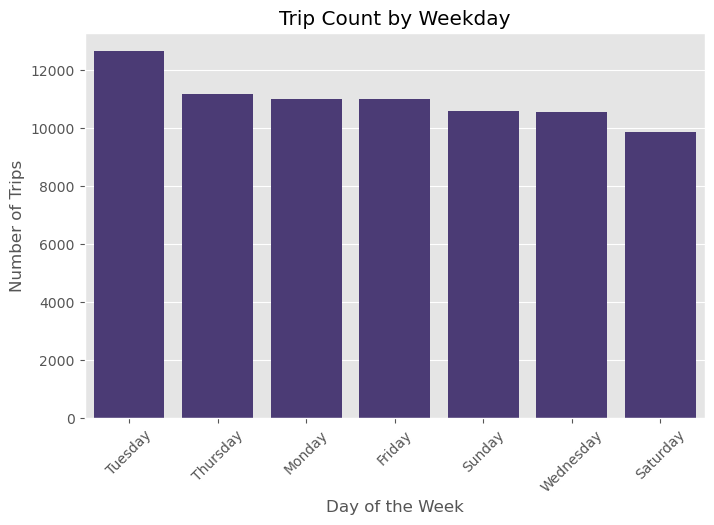

In [12]:
# Visualize Weekday Counts
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='weekday', order=df['weekday'].value_counts().index)
plt.title('Trip Count by Weekday')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Trips')
plt.xticks(rotation=45)
plt.show()


In [13]:
# e) Extract hour of day and value_counts()
df["hourofday"] = df["lpep_dropoff_datetime"].dt.hour
print("\n--- Hour of Day Extraction ---")
print(df[["lpep_dropoff_datetime", "hourofday"]].head())
print("\nHour of Day Value Counts:")
print(df["hourofday"].value_counts(dropna=False).sort_index())



--- Hour of Day Extraction ---
  lpep_dropoff_datetime  hourofday
0   2022-05-01 00:27:47          0
1   2022-05-01 01:22:01          1
2   2022-05-01 00:11:56          0
3   2022-05-01 00:48:41          0
4   2022-04-30 23:38:37         23

Hour of Day Value Counts:
hourofday
0     1666
1      970
2      609
3      452
4      413
5      405
6     1090
7     2533
8     3559
9     4146
10    4194
11    4491
12    4652
13    4411
14    4777
15    5168
16    5301
17    5458
18    5889
19    5185
20    3664
21    2909
22    2518
23    2273
Name: count, dtype: int64


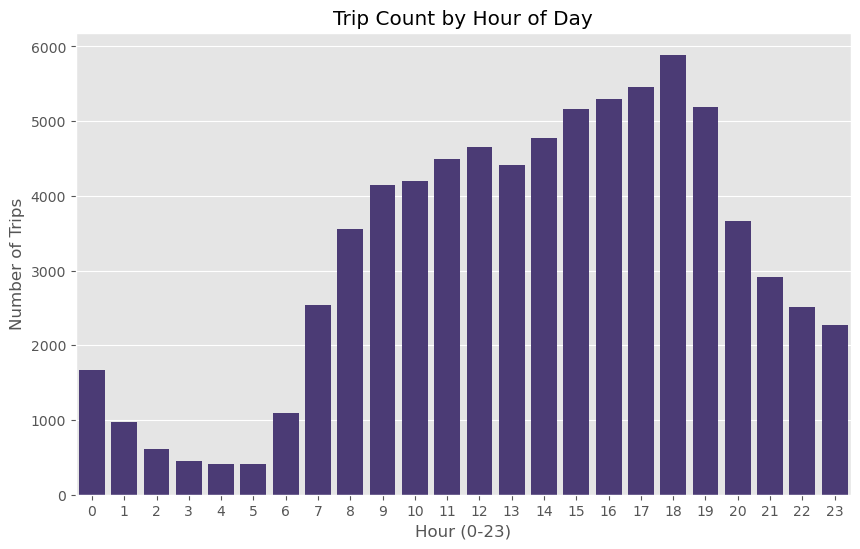

In [14]:
# Visualize Hour of Day Counts
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='hourofday', order=sorted(df['hourofday'].unique()))
plt.title('Trip Count by Hour of Day')
plt.xlabel('Hour (0-23)')
plt.ylabel('Number of Trips')
plt.show()


In [15]:
# o) Define numeric variables
numeric_cols = ['trip_distance', 'fare_amount', 'extra', 'mta_tax', 'tip_amount',
                'tolls_amount', 'improvement_surcharge', 'congestion_surcharge',
                'trip_duration', 'passenger_count', 'total_amount'] # Added total_amount for imputation if needed

# p) Define object/categorical variables (ensure these exist after previous steps)
object_cols = ['store_and_fwd_flag', 'RatecodeID', 'payment_type', 'trip_type',
               'weekday', 'hourofday'] # Adjusted based on user spec and created features


In [16]:
# Check which columns actually exist in the DataFrame
numeric_cols_exist = [col for col in numeric_cols if col in df.columns]
object_cols_exist = [col for col in object_cols if col in df.columns]

print("\n--- Missing Values Before Imputation ---")
missing_vals = df.isnull().sum()
print(missing_vals[missing_vals > 0])



--- Missing Values Before Imputation ---
store_and_fwd_flag      10437
RatecodeID              10437
passenger_count         10437
payment_type            10437
trip_type               10437
congestion_surcharge    10437
dtype: int64


In [17]:
# Impute numeric columns with median
for col in numeric_cols_exist:
    if df[col].isnull().sum() > 0:
        median_val = df[col].median()
        df[col] = df[col].fillna(median_val)
        print(f"Imputed missing values in '{col}' with median ({median_val}).")


Imputed missing values in 'congestion_surcharge' with median (0.0).
Imputed missing values in 'passenger_count' with median (1.0).


In [18]:
# Impute object/categorical columns with mode
# Note: RatecodeID, payment_type, trip_type might be better treated as numeric if they represent codes,
# but following user spec (p) and treating as object for mode imputation.
for col in object_cols_exist:
     # Check if the column is actually object/category type before mode imputation
    if df[col].dtype == 'object' or pd.api.types.is_categorical_dtype(df[col]):
        if df[col].isnull().sum() > 0:
            mode_val = df[col].mode()[0]
            df[col] = df[col].fillna(mode_val)
            print(f"Imputed missing values in '{col}' with mode ('{mode_val}').")
    # If it's a numeric-like categorical (e.g., RatecodeID), median might be better if mode imputation feels wrong
    elif pd.api.types.is_numeric_dtype(df[col]):
         if df[col].isnull().sum() > 0:
            median_val = df[col].median() # Or mode if preferred: df[col].mode()[0]
            df[col] = df[col].fillna(median_val)
            print(f"Imputed missing values in numeric-like categorical '{col}' with median ({median_val}).")


print("\n--- Missing Values After Imputation ---")
print(df[numeric_cols_exist + object_cols_exist].isnull().sum().sum()) # Should be 0 if all handled


Imputed missing values in 'store_and_fwd_flag' with mode ('N').
Imputed missing values in numeric-like categorical 'RatecodeID' with median (1.0).
Imputed missing values in numeric-like categorical 'payment_type' with median (1.0).
Imputed missing values in numeric-like categorical 'trip_type' with median (1.0).

--- Missing Values After Imputation ---
0


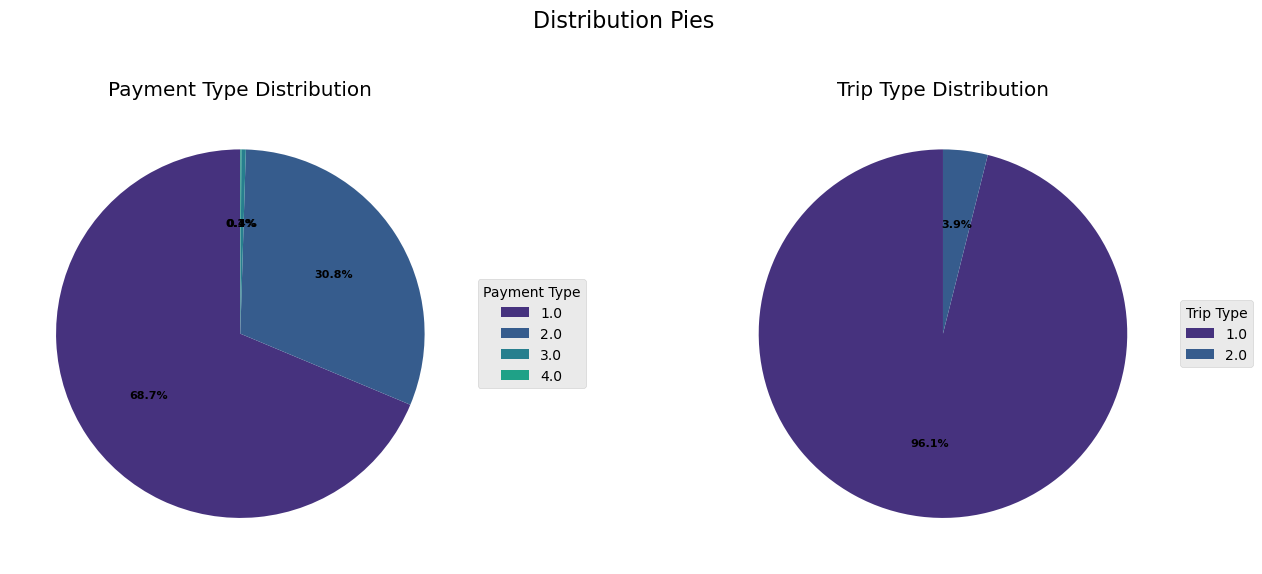

In [19]:
# g) Pie diagrams of payment_type, trip_type

# Check if columns exist before plotting
plot_cols = ['payment_type', 'trip_type']
existing_plot_cols = [col for col in plot_cols if col in df.columns]

if existing_plot_cols:
    fig, axes = plt.subplots(1, len(existing_plot_cols), figsize=(7 * len(existing_plot_cols), 6), squeeze=False)
    fig.suptitle('Distribution Pies', fontsize=16)

    for i, col in enumerate(existing_plot_cols):
        # Ensure counts are above zero before plotting pie
        counts = df[col].value_counts()
        valid_counts = counts[counts > 0]
        if not valid_counts.empty:
             wedges, texts, autotexts = axes[0, i].pie(valid_counts, autopct='%1.1f%%', startangle=90,
                                                       textprops={'fontsize': 10})
             axes[0, i].set_title(f'{col.replace("_", " ").title()} Distribution')
             axes[0, i].legend(wedges, valid_counts.index, title=col.replace("_", " ").title(), loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
             plt.setp(autotexts, size=8, weight="bold")
        else:
            axes[0,i].text(0.5, 0.5, 'No data to display', horizontalalignment='center', verticalalignment='center')
            axes[0, i].set_title(f'{col.replace("_", " ").title()} Distribution')
            axes[0,i].set_xticks([])
            axes[0,i].set_yticks([])


    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
    plt.show()
else:
    print("Columns 'payment_type' or 'trip_type' not found for pie charts.")




--- Average Total Amount by Weekday ---
weekday
Sunday       20.314733
Friday       20.057364
Saturday     19.978718
Tuesday      19.413558
Monday       19.343005
Thursday     19.297198
Wednesday    19.290314
Name: total_amount, dtype: float64


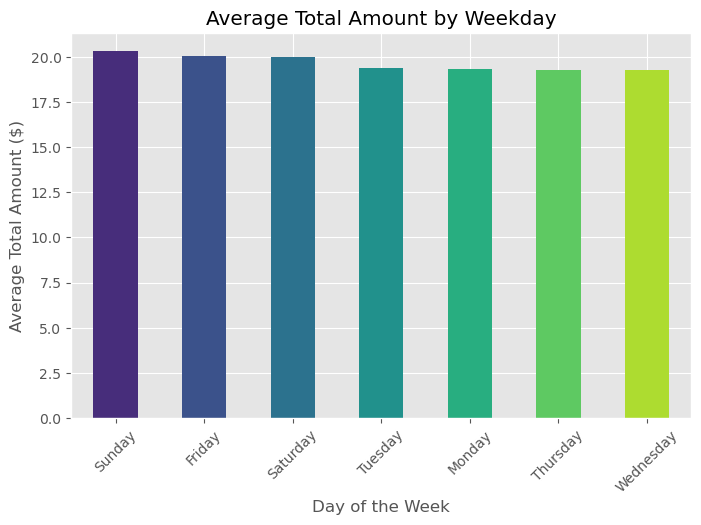

In [20]:
# h) Groupby average total_amount by weekday
if 'weekday' in df.columns and 'total_amount' in df.columns:
    weekday_avg_total = df.groupby('weekday')['total_amount'].mean().sort_values(ascending=False)
    print("\n--- Average Total Amount by Weekday ---")
    print(weekday_avg_total)

    plt.figure(figsize=(8, 5))
    weekday_avg_total.plot(kind='bar', color=sns.color_palette("viridis", len(weekday_avg_total)))
    plt.title('Average Total Amount by Weekday')
    plt.ylabel('Average Total Amount ($)')
    plt.xlabel('Day of the Week')
    plt.xticks(rotation=45)
    plt.show()
else:
    print("Required columns ('weekday', 'total_amount') not found for groupby analysis (h).")



--- Average Total Amount by Payment Type ---
payment_type
1.0    21.610406
2.0    15.553189
4.0     5.346269
3.0     3.454080
Name: total_amount, dtype: float64


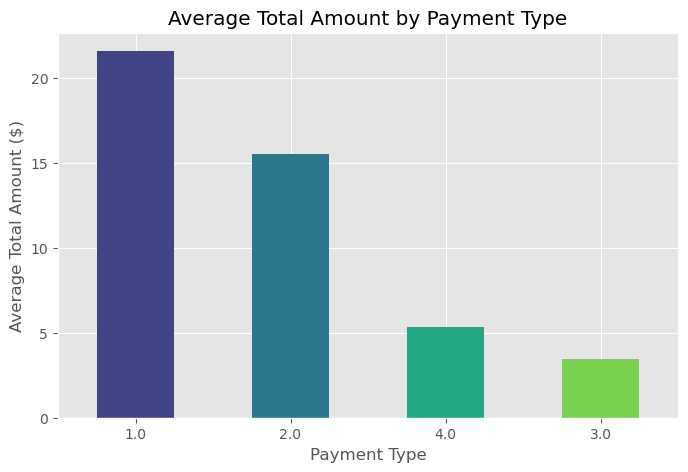

In [21]:
# i) Groupby average total_amount by payment_type
if 'payment_type' in df.columns and 'total_amount' in df.columns:
    payment_avg_total = df.groupby('payment_type')['total_amount'].mean().sort_values(ascending=False)
    print("\n--- Average Total Amount by Payment Type ---")
    print(payment_avg_total)

    plt.figure(figsize=(8, 5))
    payment_avg_total.plot(kind='bar', color=sns.color_palette("viridis", len(payment_avg_total)))
    plt.title('Average Total Amount by Payment Type')
    plt.ylabel('Average Total Amount ($)')
    plt.xlabel('Payment Type')
    plt.xticks(rotation=0)
    plt.show()
else:
     print("Required columns ('payment_type', 'total_amount') not found for groupby analysis (i).")



--- Average Tip Amount by Weekday ---
weekday
Sunday       2.303744
Saturday     2.239109
Friday       2.158359
Monday       2.103243
Thursday     2.042309
Tuesday      2.036579
Wednesday    2.028211
Name: tip_amount, dtype: float64


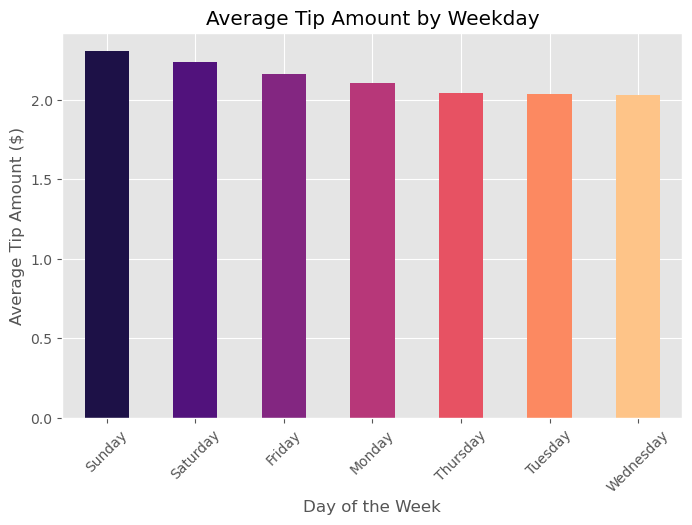

In [22]:
# j) Groupby average tip_amount by weekday
if 'weekday' in df.columns and 'tip_amount' in df.columns:
    weekday_avg_tip = df.groupby('weekday')['tip_amount'].mean().sort_values(ascending=False)
    print("\n--- Average Tip Amount by Weekday ---")
    print(weekday_avg_tip)

    plt.figure(figsize=(8, 5))
    weekday_avg_tip.plot(kind='bar', color=sns.color_palette("magma", len(weekday_avg_tip)))
    plt.title('Average Tip Amount by Weekday')
    plt.ylabel('Average Tip Amount ($)')
    plt.xlabel('Day of the Week')
    plt.xticks(rotation=45)
    plt.show()
else:
     print("Required columns ('weekday', 'tip_amount') not found for groupby analysis (j).")



--- Average Tip Amount by Payment Type ---
payment_type
1.0    3.094981
2.0    0.000000
4.0    0.000000
3.0   -0.038763
Name: tip_amount, dtype: float64


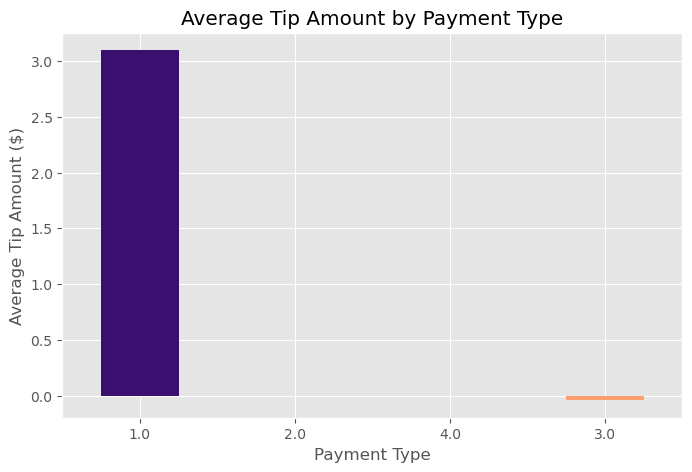

In [23]:
# k) Groupby average tip_amount by payment_type
if 'payment_type' in df.columns and 'tip_amount' in df.columns:
    payment_avg_tip = df.groupby('payment_type')['tip_amount'].mean().sort_values(ascending=False)
    print("\n--- Average Tip Amount by Payment Type ---")
    print(payment_avg_tip)

    plt.figure(figsize=(8, 5))
    payment_avg_tip.plot(kind='bar', color=sns.color_palette("magma", len(payment_avg_tip)))
    plt.title('Average Tip Amount by Payment Type')
    plt.ylabel('Average Tip Amount ($)')
    plt.xlabel('Payment Type')
    plt.xticks(rotation=0)
    plt.show()
else:
     print("Required columns ('payment_type', 'tip_amount') not found for groupby analysis (k).")


In [24]:
# l) Test null hypothesis: average total_amount of different trip_type is identical
trip_type_groups = [df[df['trip_type'] == i]['total_amount'] for i in df['trip_type'].unique()]
f_val, p_val = stats.f_oneway(*trip_type_groups)
print(f"ANOVA test for trip_type: F-value = {f_val}, p-value = {p_val}")

ANOVA test for trip_type: F-value = 2708.67257919429, p-value = 0.0


In [25]:
# m) Test null hypothesis: average total_amount of different weekday is identical
weekday_groups = [df[df['weekday'] == day]['total_amount'] for day in df['weekday'].unique()]
f_val, p_val = stats.f_oneway(*weekday_groups)
print(f"ANOVA test for weekday: F-value = {f_val}, p-value = {p_val}")

ANOVA test for weekday: F-value = 8.055322238310943, p-value = 1.0207671063868095e-08


In [26]:
# n) Test null hypothesis: no association between trip_type and payment_type
contingency_table = pd.crosstab(df['trip_type'], df['payment_type'])
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
print(f"Chi-square test: Chi2 = {chi2}, p-value = {p}")

Chi-square test: Chi2 = 160.65624773014048, p-value = 1.3228371712520636e-34



--- Correlation Analysis of Numeric Variables ---


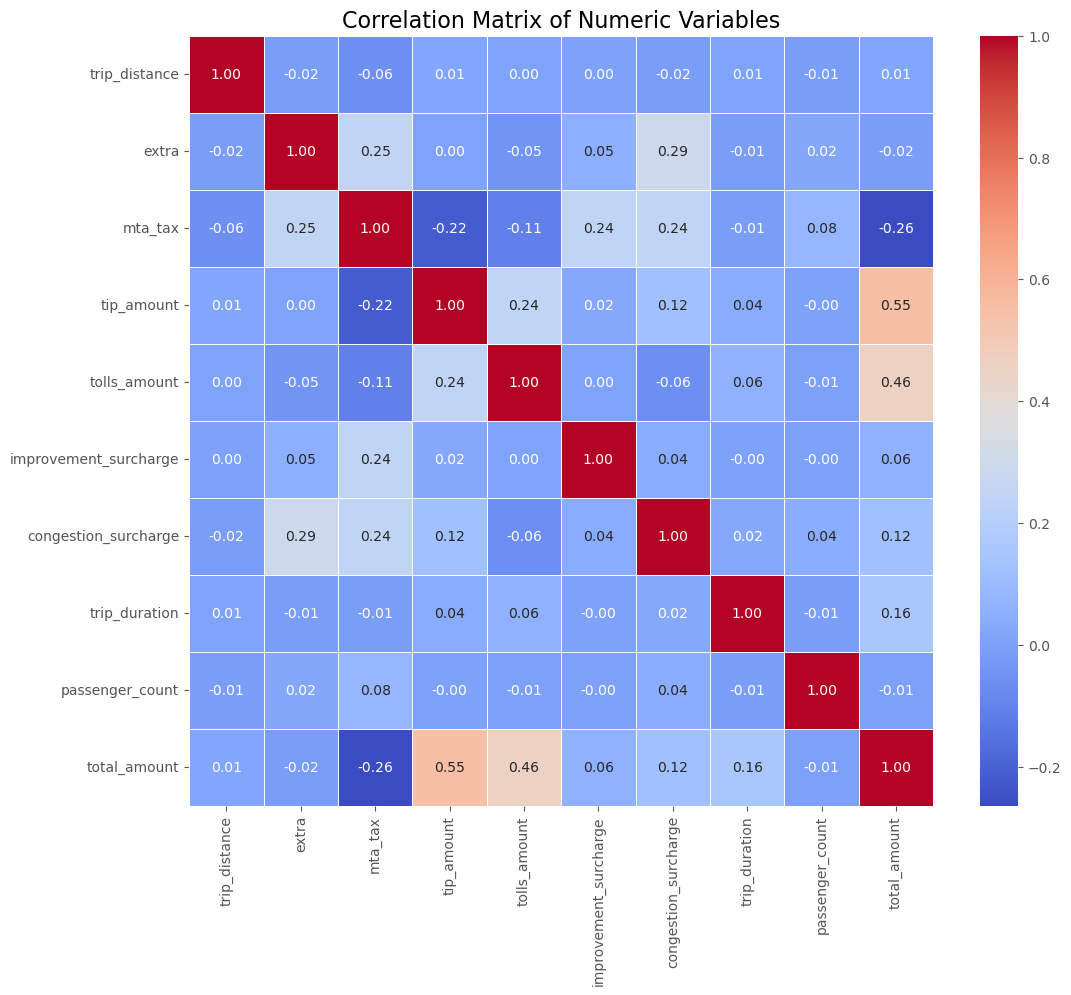


Correlation with 'total_amount':
total_amount             1.000000
tip_amount               0.546624
tolls_amount             0.458010
trip_duration            0.156783
congestion_surcharge     0.123175
improvement_surcharge    0.063815
trip_distance            0.014485
passenger_count         -0.006073
extra                   -0.016726
mta_tax                 -0.264487
Name: total_amount, dtype: float64


In [27]:
# q) Correlation analysis of numeric cols
# Using the list defined in step (o) and ensuring they exist
print("\n--- Correlation Analysis of Numeric Variables ---")
numeric_cols_for_corr = [col for col in numeric_cols if col in df.columns] # Refresh list based on current df

if len(numeric_cols_for_corr) > 1:
    corr_matrix = df[numeric_cols_for_corr].corr()

    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
    plt.title('Correlation Matrix of Numeric Variables', fontsize=16)
    plt.show()

    print("\nCorrelation with 'total_amount':")
    print(corr_matrix['total_amount'].sort_values(ascending=False))
else:
    print("Not enough numeric columns found to calculate correlation matrix.")


In [28]:
# r) Dummy encode object cols
# Using the list defined in step (p) and ensuring they exist
object_cols_to_encode = [col for col in object_cols if col in df.columns and df[col].dtype == 'object']
# Add numeric categorical cols if they should be one-hot encoded (e.g., RatecodeID if not ordinal)
numeric_cats_to_encode = ['RatecodeID', 'payment_type', 'trip_type'] 
object_cols_to_encode.extend([col for col in numeric_cats_to_encode if col in df.columns and col not in object_cols_to_encode])
# Ensure no duplicates
object_cols_to_encode = list(set(object_cols_to_encode))
df_encoded = pd.get_dummies(df, columns=object_cols_to_encode, drop_first=True) # drop_first=True to avoid multicollinearity




--- Dependent Variable Analysis: total_amount ---


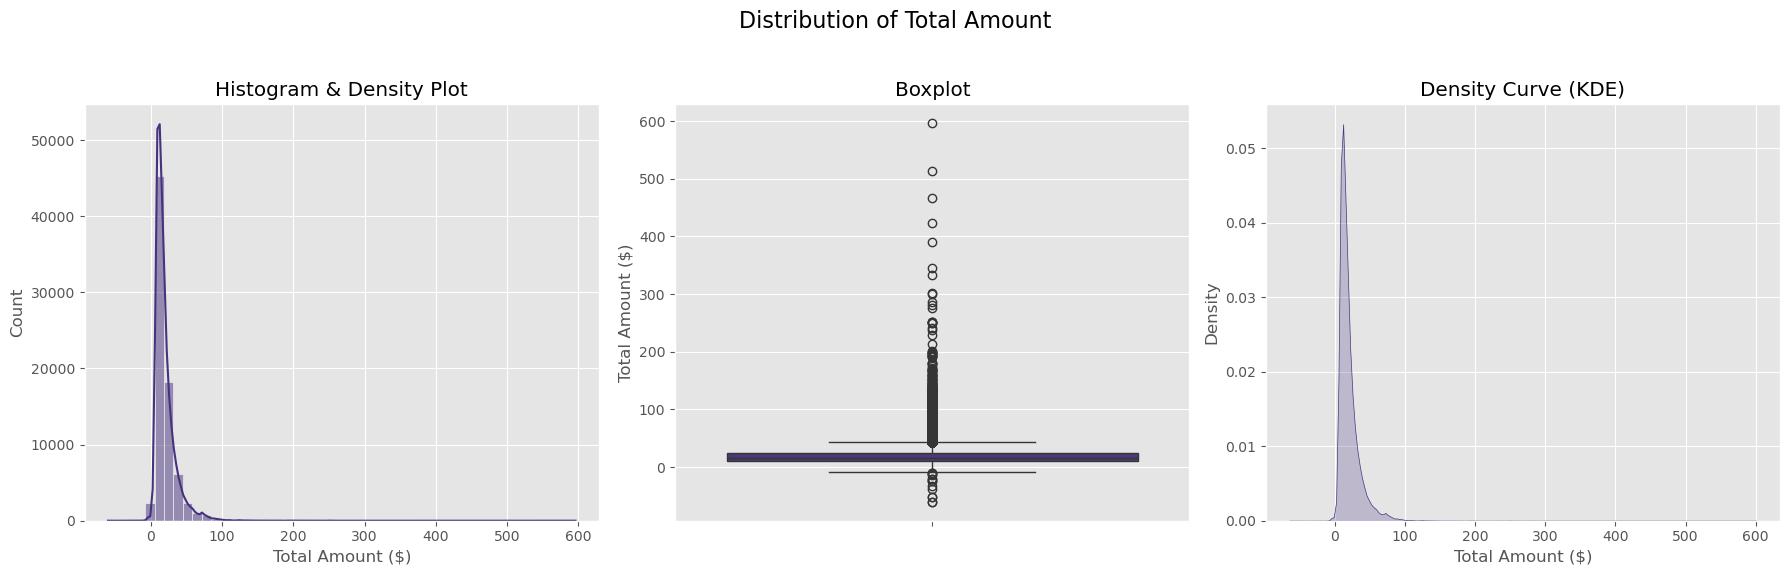


Total amount is skewed (skewness: 4.93). Consider log transformation.


In [29]:
# s) Dependent Variable (total_amount) Analysis: Histogram, Boxplot, Density Curve
if 'total_amount' in df_encoded.columns:
    print("\n--- Dependent Variable Analysis: total_amount ---")
    plt.figure(figsize=(18, 6))
    plt.suptitle('Distribution of Total Amount', fontsize=16)

    # Histogram
    plt.subplot(1, 3, 1)
    sns.histplot(df_encoded['total_amount'], kde=True, bins=50)
    plt.title('Histogram & Density Plot')
    plt.xlabel('Total Amount ($)')

    # Boxplot
    plt.subplot(1, 3, 2)
    sns.boxplot(y=df_encoded['total_amount'])
    plt.title('Boxplot')
    plt.ylabel('Total Amount ($)')

    # Density Curve (KDE)
    plt.subplot(1, 3, 3)
    sns.kdeplot(df_encoded['total_amount'], shade=True)
    plt.title('Density Curve (KDE)')
    plt.xlabel('Total Amount ($)')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    # Consider log transformation if highly skewed
    if df_encoded['total_amount'].skew() > 1 or df_encoded['total_amount'].skew() < -1 :
        print(f"\nTotal amount is skewed (skewness: {df_encoded['total_amount'].skew():.2f}). Consider log transformation.")
        # df_encoded['total_amount_log'] = np.log1p(df_encoded['total_amount']) # Example
else:
    print("\n'total_amount' column not found for dependent variable analysis.")


In [40]:
# Define Features (X) and Target (y)
# Exclude target variable, original datetime columns, and potentially ID columns like VendorID if present
cols_to_exclude = ['total_amount', 'lpep_pickup_datetime', 'lpep_dropoff_datetime', 'VendorID']
# Also exclude original categorical columns that were encoded
cols_to_exclude.extend(object_cols_to_encode) # Remove originals
features = [col for col in df_encoded.columns if col not in cols_to_exclude and df_encoded[col].dtype != 'object']
# Ensure only numeric types remain in features
X = df_encoded[features].select_dtypes(include=np.number)
y = df_encoded['total_amount']


In [41]:
# Check for NaN/inf values introduced during calculations or missed during imputation
if X.isnull().sum().sum() > 0 or np.isinf(X.values).sum() > 0:
    print("\nWarning: NaN or Infinite values found in features (X). Re-imputing with 0.")
    X = X.fillna(0).replace([np.inf, -np.inf], 0) # Simple imputation, adjust if needed

In [42]:
# Split Data into Training and Testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"\nTrain set shape: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Test set shape: X_test={X_test.shape}, y_test={y_test.shape}")


Train set shape: X_train=(61386, 12), y_train=(61386,)
Test set shape: X_test=(15347, 12), y_test=(15347,)


In [43]:
# Function to evaluate and visualize model performance
def evaluate_model(model_name, y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"\n--- {model_name} Evaluation ---")
    print(f"RMSE: {rmse:.4f}")
    print(f"R2 Score: {r2:.4f}")
    
    # Plotting predictions vs actuals
    plt.figure(figsize=(8, 8))
    plt.scatter(y_true, y_pred, alpha=0.3)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], '--r', linewidth=2)
    plt.xlabel("Actual Total Amount")
    plt.ylabel("Predicted Total Amount")
    plt.title(f"{model_name}: Actual vs Predicted")
    plt.show()
    
    return {'RMSE': rmse, 'R2 Score': r2}


--- Training Multiple Linear Regression ---

--- Multiple Linear Regression Evaluation ---
RMSE: 10.4360
R2 Score: 0.5164


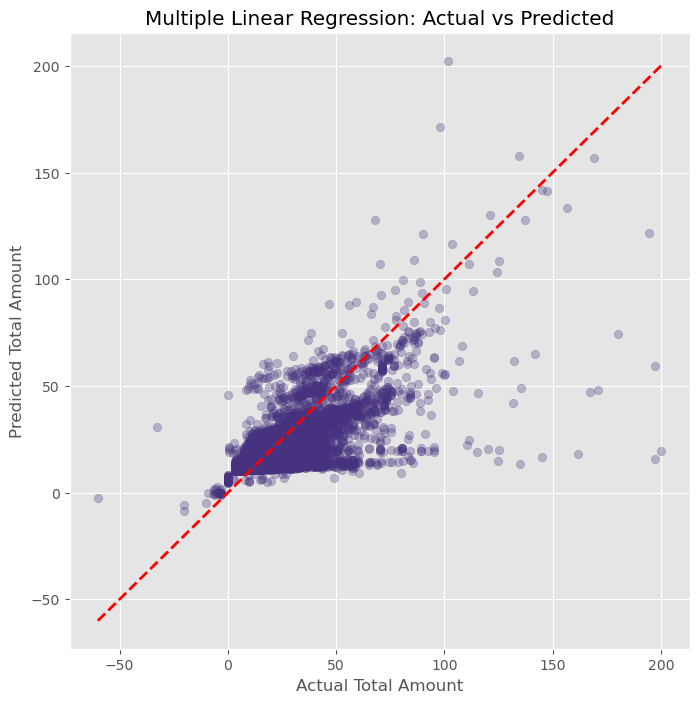


Linear Regression Coefficients (Feature Importance):
                  Feature  Coefficient
8   improvement_surcharge    45.388863
7            tolls_amount     3.657552
9    congestion_surcharge     1.833465
6              tip_amount     1.786371
2         passenger_count     0.114300
4                   extra     0.040857
10          trip_duration     0.026639
0            PULocationID     0.015003
1            DOLocationID     0.001714
3           trip_distance    -0.000016


In [44]:
results = {}

# ========== 1. Multiple Linear Regression ==========
print("\n--- Training Multiple Linear Regression ---")
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
linear_pred = linear_model.predict(X_test)
results["Multiple Linear Regression"] = evaluate_model("Multiple Linear Regression", y_test, linear_pred)

# Feature importance for linear regression (coefficients)
if hasattr(linear_model, 'coef_'):
    coefficients = pd.DataFrame({
        'Feature': X.columns,
        'Coefficient': linear_model.coef_
    })
    print("\nLinear Regression Coefficients (Feature Importance):")
    print(coefficients.sort_values('Coefficient', ascending=False).head(10))


--- Training Decision Tree Regressor ---

--- Decision Tree Evaluation ---
RMSE: 10.0634
R2 Score: 0.5503


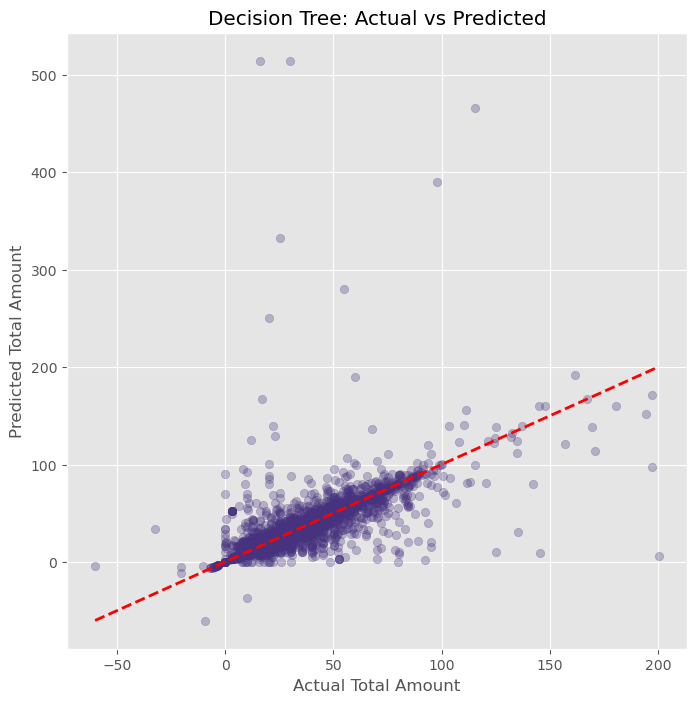


Decision Tree Feature Importance:
                  Feature  Importance
3           trip_distance    0.526446
10          trip_duration    0.178566
6              tip_amount    0.145950
0            PULocationID    0.040936
1            DOLocationID    0.029577
5                 mta_tax    0.020058
11              hourofday    0.018185
7            tolls_amount    0.014912
8   improvement_surcharge    0.009609
2         passenger_count    0.009577


In [45]:
# ========== 2. Decision Tree Regressor ==========
print("\n--- Training Decision Tree Regressor ---")
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train)
dt_pred = dt_model.predict(X_test)
results["Decision Tree"] = evaluate_model("Decision Tree", y_test, dt_pred)

# Feature importance for decision tree
if hasattr(dt_model, 'feature_importances_'):
    dt_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': dt_model.feature_importances_
    })
    print("\nDecision Tree Feature Importance:")
    print(dt_importance.sort_values('Importance', ascending=False).head(10))



--- Training Random Forest Regressor ---

--- Random Forest (100 trees) Evaluation ---
RMSE: 5.8884
R2 Score: 0.8460


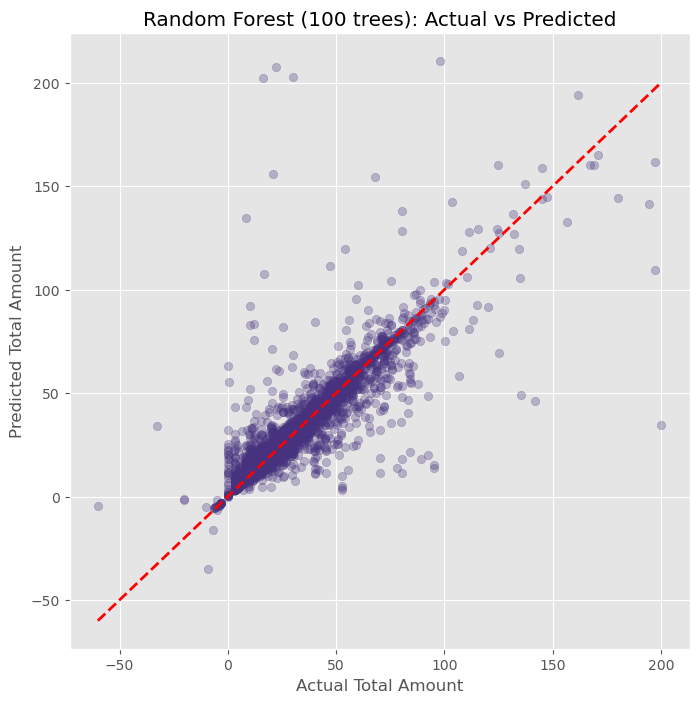


Random Forest Feature Importance:
                  Feature  Importance
3           trip_distance    0.533754
10          trip_duration    0.175345
6              tip_amount    0.143263
0            PULocationID    0.034480
1            DOLocationID    0.030900
11              hourofday    0.022119
7            tolls_amount    0.019180
5                 mta_tax    0.018762
8   improvement_surcharge    0.008172
2         passenger_count    0.007007


In [46]:
# ========== 3. Random Forest Regressor ==========
print("\n--- Training Random Forest Regressor ---")
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
# Use consistent naming for the model
model_name = "Random Forest (100 trees)"
results[model_name] = evaluate_model(model_name, y_test, rf_pred)

# Feature importance for random forest
if hasattr(rf_model, 'feature_importances_'):
    rf_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': rf_model.feature_importances_
    })
    print("\nRandom Forest Feature Importance:")
    print(rf_importance.sort_values('Importance', ascending=False).head(10))


--- Training Gradient Boosting Regressor ---

--- Gradient Boosting (100 trees) Evaluation ---
RMSE: 5.4763
R2 Score: 0.8668


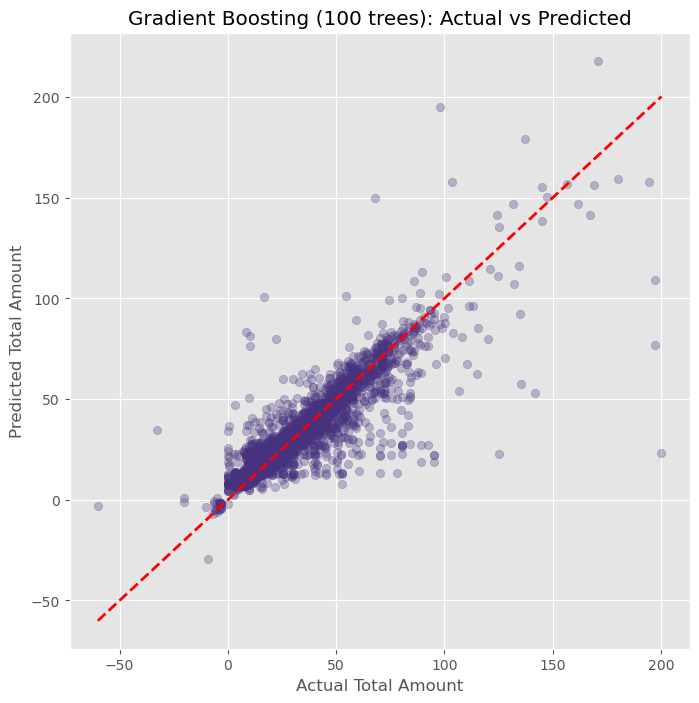


Gradient Boosting Feature Importance:
                  Feature  Importance
3           trip_distance    0.526723
10          trip_duration    0.221856
6              tip_amount    0.164201
7            tolls_amount    0.029172
5                 mta_tax    0.026724
8   improvement_surcharge    0.006166
9    congestion_surcharge    0.006062
1            DOLocationID    0.005514
2         passenger_count    0.004686
0            PULocationID    0.003494


In [47]:
# ========== 4. Gradient Boosting Regressor ==========
print("\n--- Training Gradient Boosting Regressor ---")
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)
gb_pred = gb_model.predict(X_test)
# Use consistent naming for the model
model_name = "Gradient Boosting (100 trees)"
results[model_name] = evaluate_model(model_name, y_test, gb_pred)

# Feature importance for gradient boosting
if hasattr(gb_model, 'feature_importances_'):
    gb_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': gb_model.feature_importances_
    })
    print("\nGradient Boosting Feature Importance:")
    print(gb_importance.sort_values('Importance', ascending=False).head(10))


In [48]:
# Results Summary - sorted by R2 Score in descending order
print("\n--- Model Comparison ---")
results_df = pd.DataFrame(results).T
print(results_df.sort_values(by='R2 Score', ascending=False))


--- Model Comparison ---
                                    RMSE  R2 Score
Gradient Boosting (100 trees)   5.476273  0.866836
Random Forest (100 trees)       5.888385  0.846040
Decision Tree                  10.063427  0.550315
Multiple Linear Regression     10.435989  0.516403


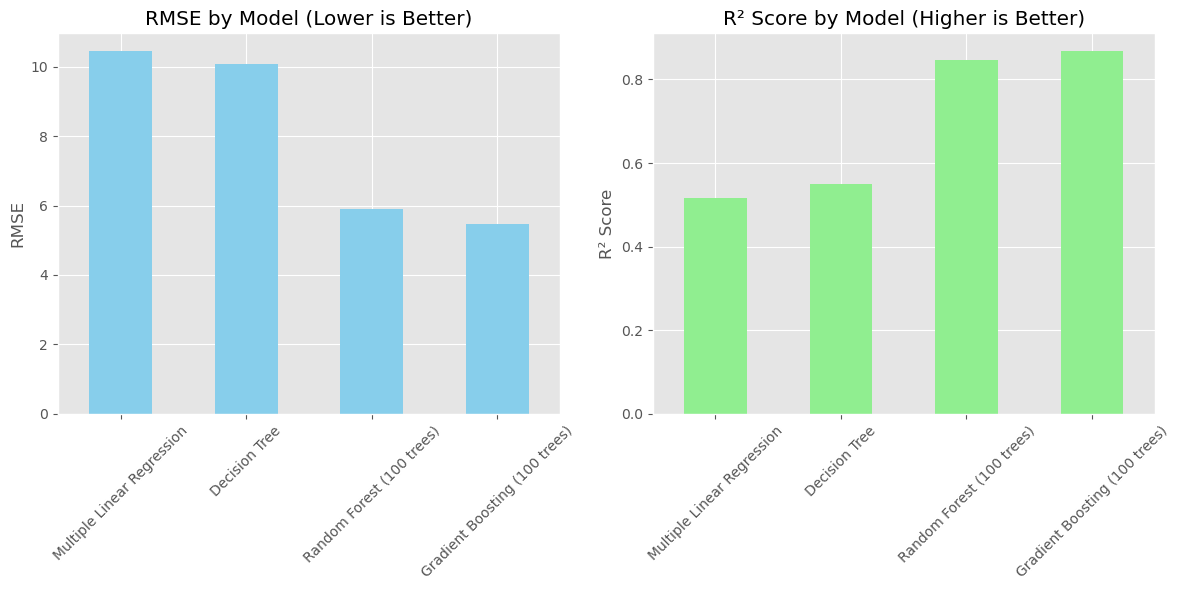

In [49]:
# Visualization of model comparison
plt.figure(figsize=(12, 6))
# Plot RMSE (lower is better)
plt.subplot(1, 2, 1)
results_df['RMSE'].plot(kind='bar', color='skyblue')
plt.title('RMSE by Model (Lower is Better)')
plt.ylabel('RMSE')    
plt.xticks(rotation=45)
    
    # Plot R2 (higher is better)
plt.subplot(1, 2, 2)
results_df['R2 Score'].plot(kind='bar', color='lightgreen')
plt.title('R² Score by Model (Higher is Better)')
plt.ylabel('R² Score')
plt.xticks(rotation=45)
   
plt.tight_layout()
plt.show()